In [6]:
!pip install tsne

     |████████████████████████████████| 552kB 10.6MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for tsne: filename=tsne-0.3.1-cp37-cp37m-linux_x86_64.whl size=260480 sha256=e0c49df0ee0738b93de1e04b114562a800e15d66dd2ccdc347a597ac49b6d42b
  Stored in directory: /root/.cache/pip/wheels/3e/d6/fc/58392f18ea8fc4c74e20185d2faeee87a1c1924a182606c6cd
Successfully built tsne


In [7]:
#import libraries

import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.patches as patches
import random
from sklearn.utils import shuffle
from glob import glob
import seaborn as sns

import torch
import torchvision.models as models
from torchvision import datasets, transforms
from torch import optim
import torch.nn.functional as F
import torch.nn as nn
from torch.utils.data.sampler import SubsetRandomSampler
import random
from termcolor import colored
from sklearn.metrics import confusion_matrix
import itertools

from sklearn.model_selection import train_test_split
from tsne import bh_sne
import matplotlib.patches as patches
from PIL import Image
from matplotlib.colors import ListedColormap
from matplotlib.gridspec import GridSpec

Loading and preprocessing data

In [8]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [9]:
!pip install zipfile38

  Created wheel for zipfile38: filename=zipfile38-0.0.3-cp37-none-any.whl size=22757 sha256=2e66d81a21d95e351325053f1960d5c7f6d7baa3bb59e0bbdd296a4d850723aa
  Stored in directory: /root/.cache/pip/wheels/15/7a/ec/508d28bf3894e050aef4d0205cdf27a346e6e0891e979345d4
Successfully built zipfile38


In [10]:
from google.colab import files

uploaded = files.upload()

Saving Kather_texture_2016_image_tiles_5000.zip to Kather_texture_2016_image_tiles_5000.zip


In [12]:
!ls

Kather_texture_2016_image_tiles_5000.zip  sample_data


In [13]:
import zipfile38 as zipfile

rf = zipfile.ZipFile('Kather_texture_2016_image_tiles_5000.zip')
for f in rf.infolist():
    print(f.filename, f.file_size)
    if f.filename == "README":
        print(rf.read(f))
rf.extractall()

Выходные данные были обрезаны до нескольких последних строк (5000).
Kather_texture_2016_image_tiles_5000/01_TUMOR/10264_CRC-Prim-HE-07_025.tif_Row_1801_Col_1.tif 68372
Kather_texture_2016_image_tiles_5000/01_TUMOR/10286_CRC-Prim-HE-01_002.tif_Row_301_Col_1.tif 68376
Kather_texture_2016_image_tiles_5000/01_TUMOR/1030D_CRC-Prim-HE-02_031.tif_Row_151_Col_1.tif 68376
Kather_texture_2016_image_tiles_5000/01_TUMOR/103B7_CRC-Prim-HE-02_026.tif_Row_1_Col_451.tif 68376
Kather_texture_2016_image_tiles_5000/01_TUMOR/103F_CRC-Prim-HE-02_025.tif_Row_1_Col_301.tif 68376
Kather_texture_2016_image_tiles_5000/01_TUMOR/103F_CRC-Prim-HE-10_013.tif_Row_151_Col_1.tif 68374
Kather_texture_2016_image_tiles_5000/01_TUMOR/10437_CRC-Prim-HE-02_028.tif_Row_151_Col_451.tif 68358
Kather_texture_2016_image_tiles_5000/01_TUMOR/104D5_CRC-Prim-HE-09_024.tif_Row_451_Col_151.tif 68374
Kather_texture_2016_image_tiles_5000/01_TUMOR/1055E_CRC-Prim-HE-01_027.tif_Row_151_Col_301.tif 68368
Kather_texture_2016_image_tiles_5000

In [14]:
base_dir = '/content/Kather_texture_2016_image_tiles_5000'

In [15]:

## Get labels of all classes in this dataset
img_labels = [i for i in os.listdir(base_dir) if not i.startswith('.')]
print('There are {} classes in this dataset:\n{}'.format(len(img_labels), img_labels))

There are 8 classes in this dataset:
['03_COMPLEX', '07_ADIPOSE', '05_DEBRIS', '02_STROMA', '08_EMPTY', '06_MUCOSA', '04_LYMPHO', '01_TUMOR']


In [16]:
tumor_files = glob(os.path.join(base_dir, img_labels[0], '*.tif'))
stroma_files = glob(os.path.join(base_dir, img_labels[1], '*.tif'))
complex_files = glob(os.path.join(base_dir, img_labels[2], '*.tif'))
lympho_files = glob(os.path.join(base_dir, img_labels[3], '*.tif'))
debris_files = glob(os.path.join(base_dir, img_labels[4], '*.tif'))
mucosa_files = glob(os.path.join(base_dir, img_labels[5], '*.tif'))
adipose_files = glob(os.path.join(base_dir, img_labels[6], '*.tif'))
empty_files = glob(os.path.join(base_dir, img_labels[7], '*.tif'))
img_files = [tumor_files, stroma_files, complex_files, lympho_files, debris_files, mucosa_files, adipose_files, empty_files]
total_files = [img for folder in img_files for img in folder]

In [17]:
print('Total number of images in this dataset: {}'.format(len(total_files)))
print ('-'*50)
for i in np.arange(8):
    print('Number of images for {} category: {}'.format(img_labels[i].split('_')[1], len(img_files[i])))

Total number of images in this dataset: 5000
--------------------------------------------------
Number of images for COMPLEX category: 625
Number of images for ADIPOSE category: 625
Number of images for DEBRIS category: 625
Number of images for STROMA category: 625
Number of images for EMPTY category: 625
Number of images for MUCOSA category: 625
Number of images for LYMPHO category: 625
Number of images for TUMOR category: 625


In [18]:
## OpenCV loads color images in BGR mode. For visualization by matplotlib, images need to be converted to RGB mode
def readImage_rgb(img_path):
    '''OpenCV loads color images in BGR mode and converts to RGB mode for visualization;
       output: (H x W x n_channel)'''
    img_bgr = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    return img_rgb

In [19]:
img = readImage_rgb(img_files[0][0])
print(img.shape)

(150, 150, 3)


Short overview:
1.There are 5000 images evenly distributed in 8 classes with 625 images per class

2.multiclass classification

0: 01_TUMOR -- Tumour epithelium

1: 02_STROMA -- Simple stroma (homogeneous composition, includes tumour stroma, extra-tumoural stroma and smooth muscle)

2: 03_COMPLEX -- Complex stroma (containing single tumour cells and/or few immune cells)

3: 04_LYMPHO -- Immune cells (including immune-cell conglomerates and sub-mucosal lymphoid follicles)

4: 05_DEBRIS -- Debris (including necrosis, hemorrhage and mucus)

5: 06_MUCOSA -- Normal mucosal glands

6: 07_ADIPOSE -- Adipose tissue

7: 08_EMPTY -- Background (no tissue)

3.Image size is 150x150px, RGB mode

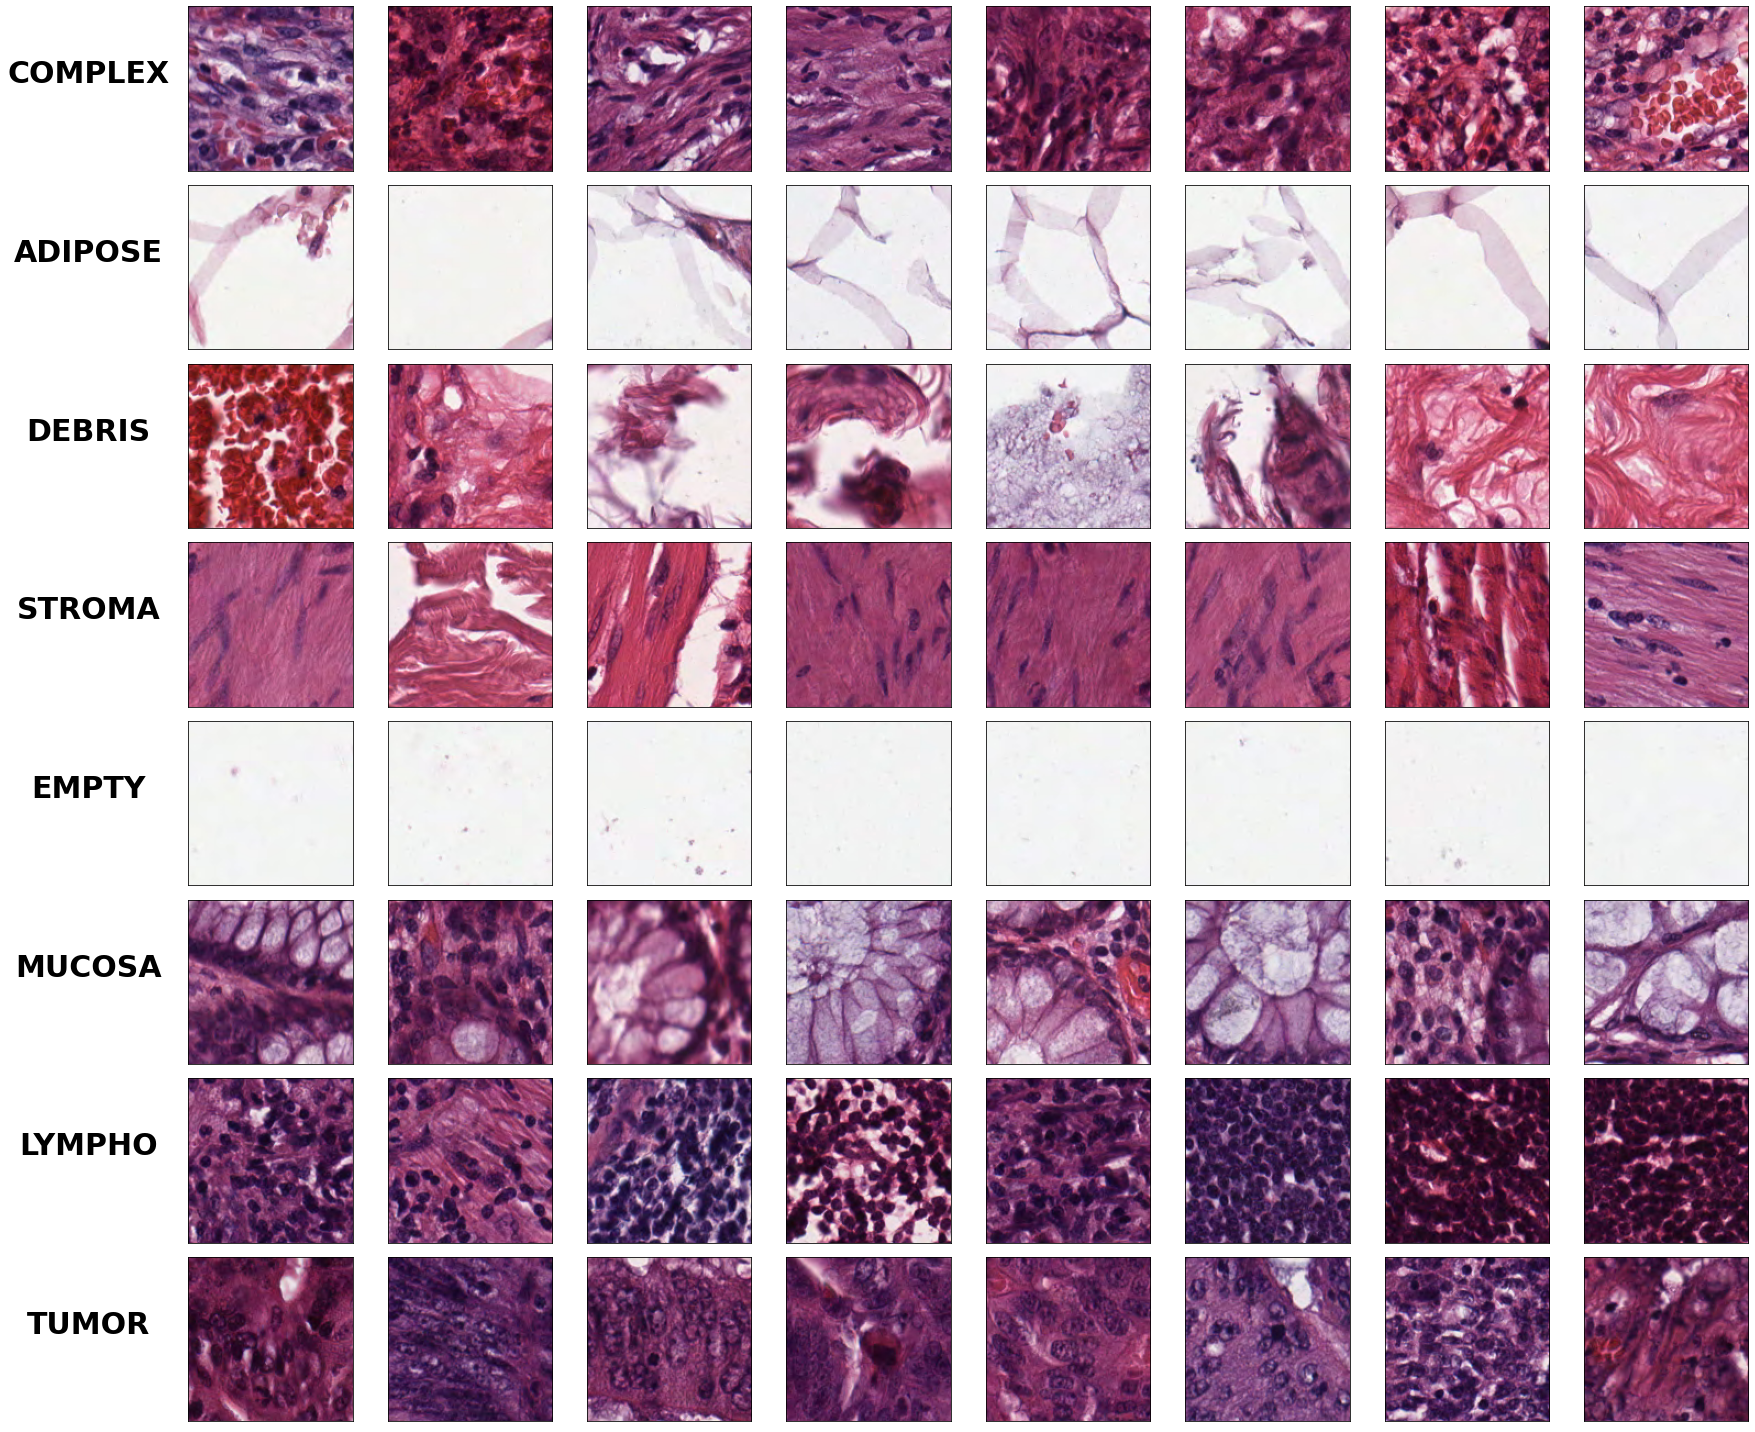

In [20]:
def plotImage_cat(img_files, img_labels):
    fig = plt.figure(figsize=(25,20))
    for i in np.arange(len(img_labels)):
        img_paths = img_files[i]
        img_label = img_labels[i]
        np.random.shuffle(img_paths)
        img_paths = img_paths[:8]
        for j, img_path in enumerate(img_paths):
            fig.add_subplot(8,8,i*8+j+1, xticks = [], yticks = [])
            plt.imshow(readImage_rgb(img_path))
            if j == 0:
                plt.ylabel(img_label.split('_')[1], rotation = 0, labelpad=100, fontsize=30, fontweight = 'bold')
    plt.tight_layout()    
    #fig.savefig('Histology.png')
plotImage_cat(img_files, img_labels)

Next, we can view individual image in each channel (RGB: red/green/blue) separately and in RGB mode

In [21]:
def plotImage_rgb(img_paths, img_label):
    '''Plot image in each of RGB (red/green/blue) channels separately and in RGB mode'''
    np.random.shuffle(img_paths)
    img_path = img_paths[0]
    img_rgb = readImage_rgb(img_path)
     
    fig = plt.figure(figsize=(20,8))
    channels = ['Red', 'Green', 'Blue']
    color = ['r','g','b']
    
    for idx in np.arange(3):
        plt.subplot(1,4,idx+1)
        img = img_rgb[:,:,idx]
        plt.imshow(img, cmap = 'gray')
        plt.title(channels[idx], color = color[idx], fontsize = 30)
        
    plt.subplot(1,4,4)
    plt.imshow(img_rgb)
    plt.title('RGB', fontsize = 30)
    fig.suptitle('H&E image of {} area'.format(img_label), fontsize = 36) 
    
    plt.tight_layout()

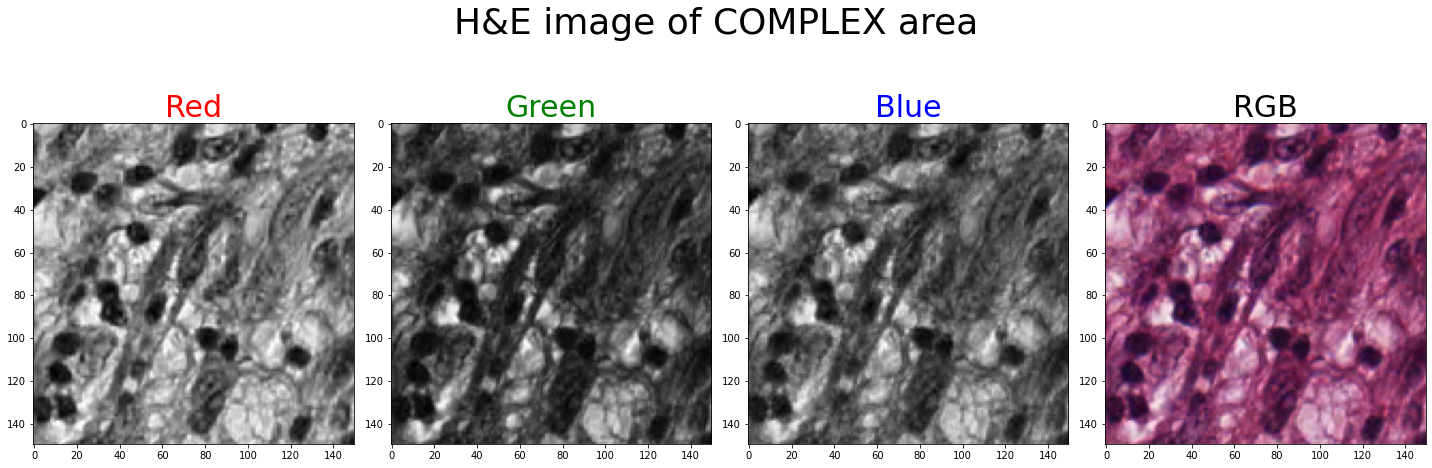

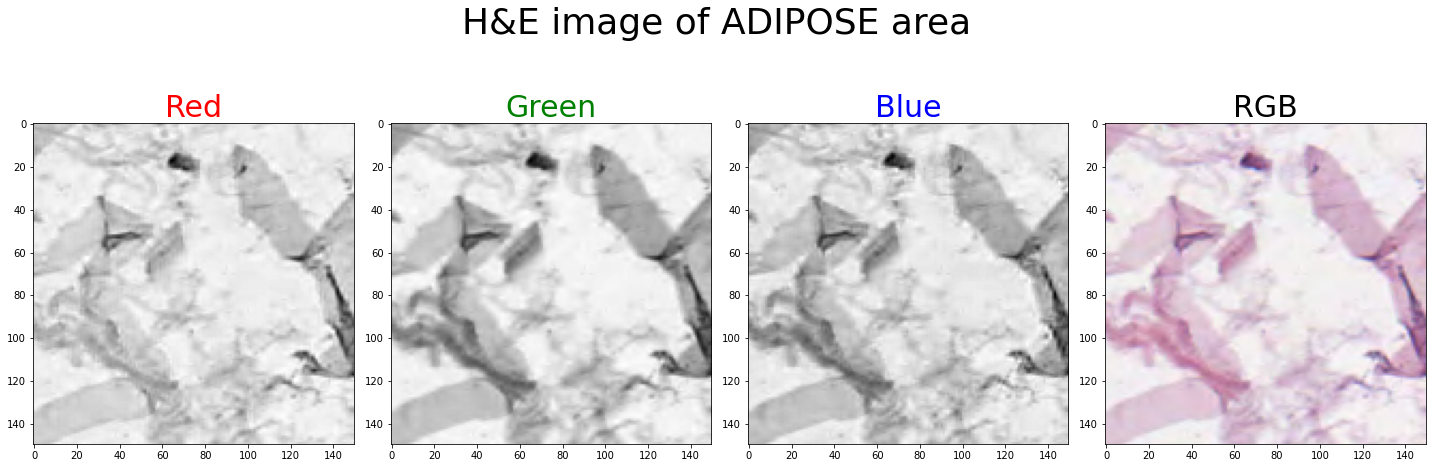

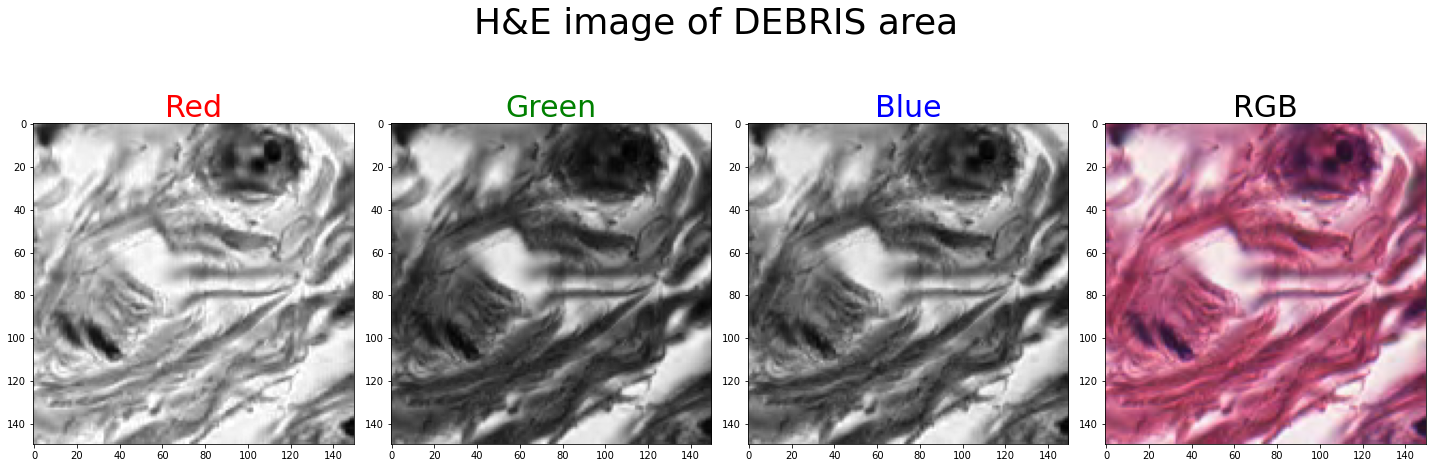

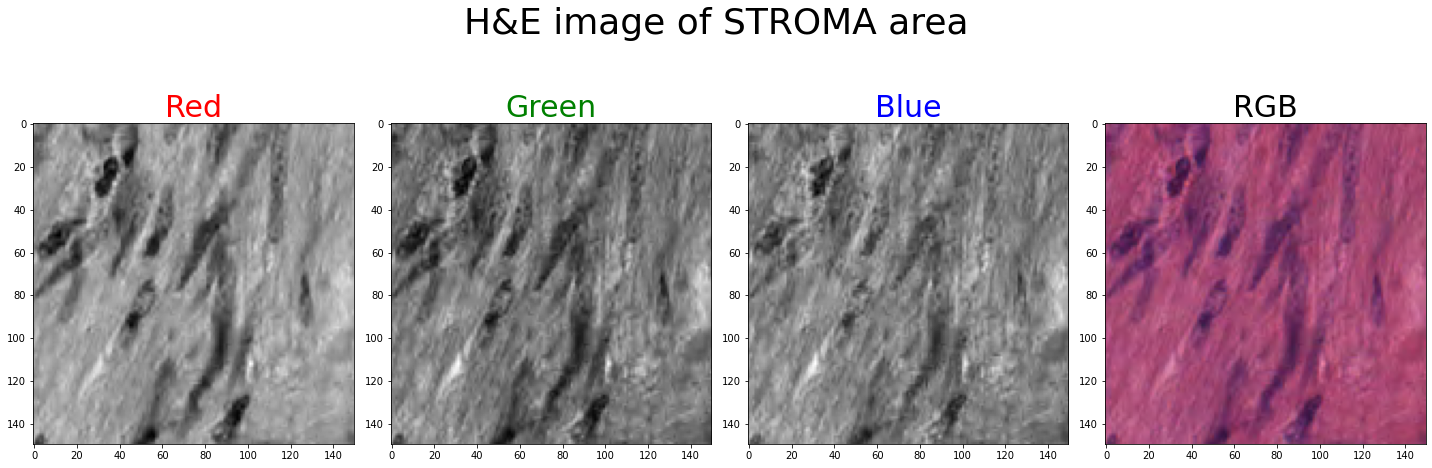

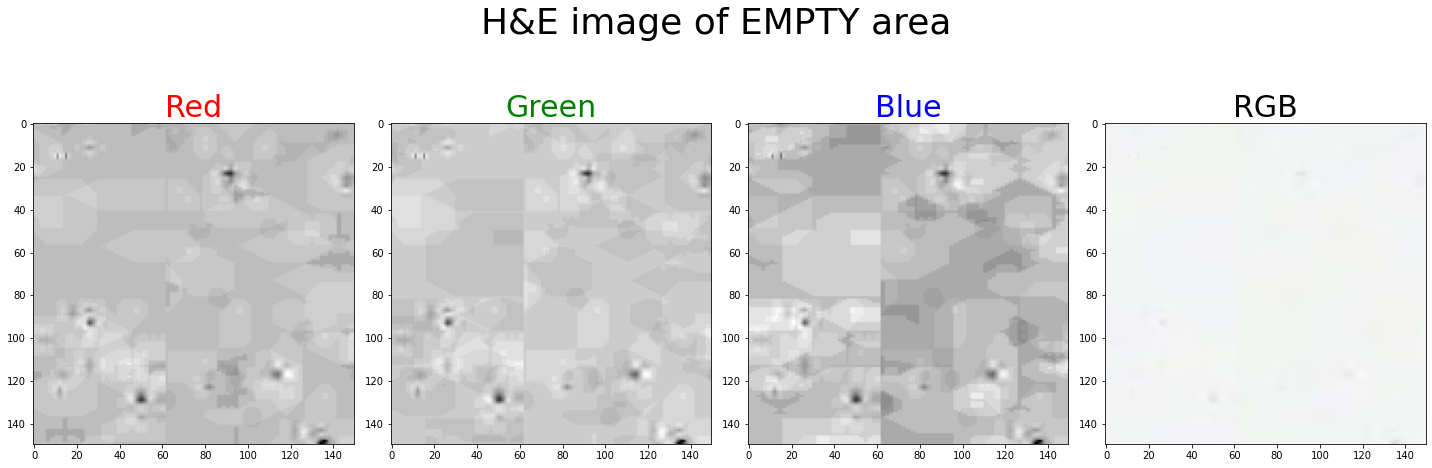

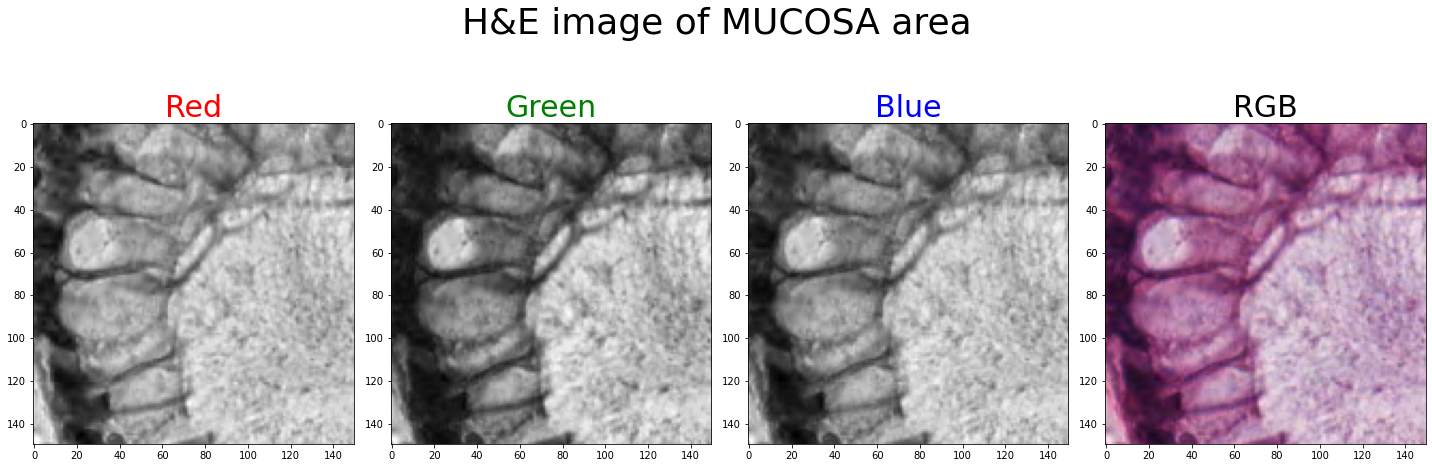

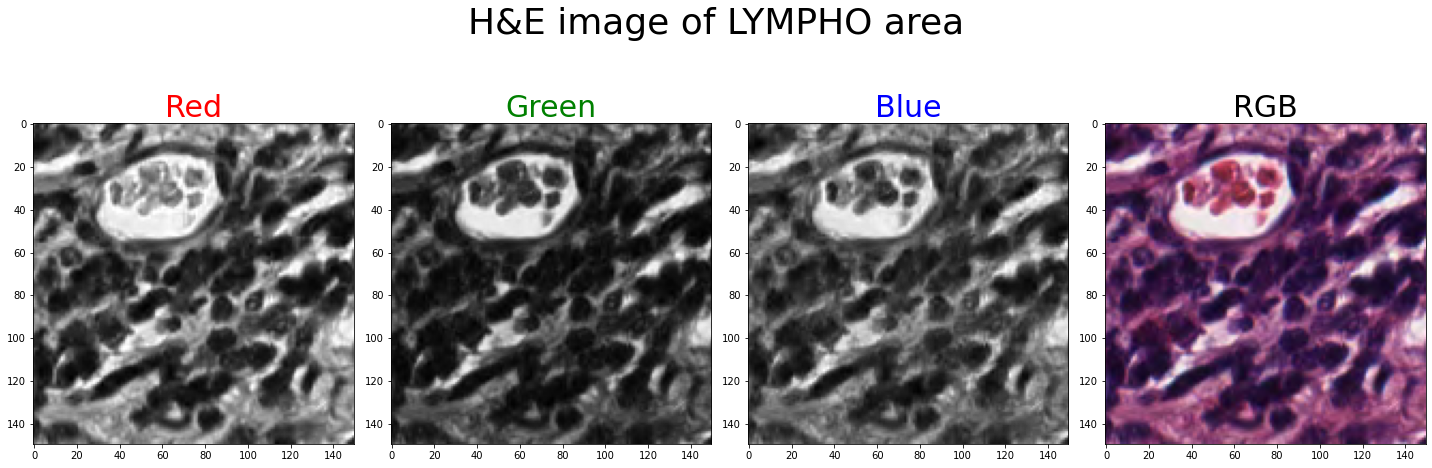

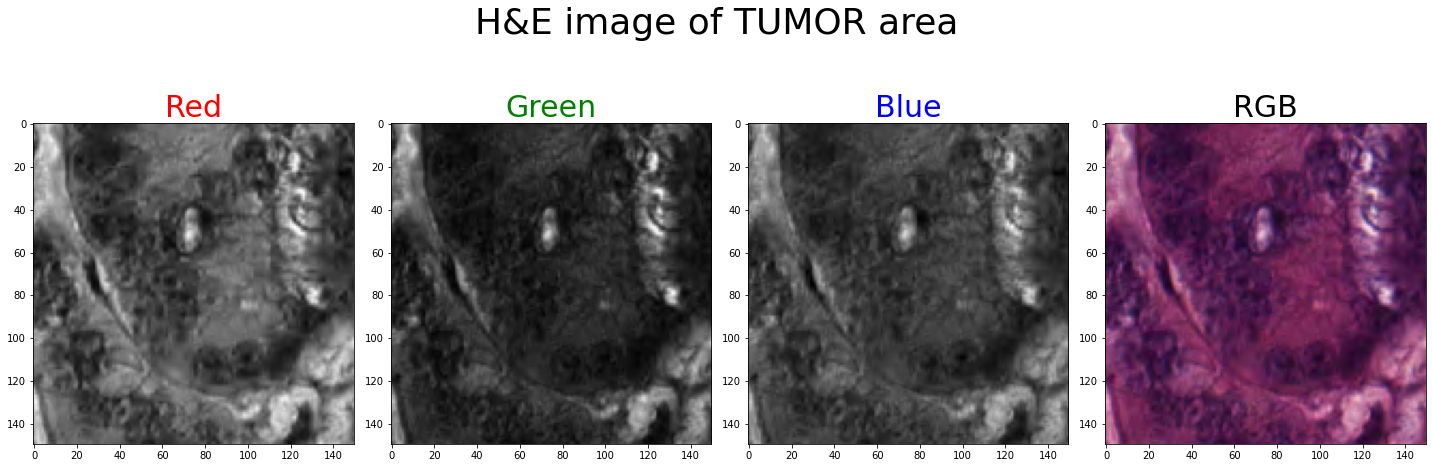

In [22]:
for i in np.arange(8):
    plotImage_rgb(img_files[i], img_labels[i].split('_')[1])




> Compute image intensity



In [23]:

def image_summary(image_paths, img_label):
    img_dict = {}
    for i in range(len(image_paths)):
        img_path = image_paths[i]
        img_dict[img_path] = {}
        img = cv2.imread(img_path)
        img_dict[img_path]['label'] = img_label
        img_dict[img_path]['max'] = img.max()
        img_dict[img_path]['min'] = img.min()
        
        channel_mean = img.mean(axis = (0,1), keepdims = True).squeeze()
        channel_std = img.std(axis = (0,1), keepdims = True).squeeze()
        channel_q01 = np.quantile(img, 0.1, axis=(0,1), keepdims=True).squeeze()
        channel_q09 = np.quantile(img, 0.9, axis=(0,1), keepdims=True).squeeze()
        img_dict[img_path]['red_mean'], img_dict[img_path]['green_mean'], img_dict[img_path]['blue_mean'] = channel_mean
        img_dict[img_path]['red_std'], img_dict[img_path]['green_std'], img_dict[img_path]['blue_std'] = channel_std
        img_dict[img_path]['red_q01'], img_dict[img_path]['green_q01'], img_dict[img_path]['blue_q01'] = channel_q01
        img_dict[img_path]['red_q09'], img_dict[img_path]['green_q09'], img_dict[img_path]['blue_q09'] = channel_q09
        
    img_df = pd.DataFrame.from_dict(img_dict, orient = 'index')
    return img_df

In [24]:
tumor_files_df = image_summary(tumor_files, 'TUMOR')
stroma_files_df = image_summary(stroma_files, 'STROMA')
complex_files_df = image_summary(complex_files, 'COMPLEX')
lympho_files_df = image_summary(lympho_files, 'LYMPHO')
debris_files_df = image_summary(debris_files, 'DEBRIS')
mucosa_files_df = image_summary(mucosa_files, 'MUCOSA')
adipose_files_df = image_summary(adipose_files, 'ADIPOSE')
empty_files_df = image_summary(empty_files, 'EMPTY')

In [25]:
pixel_df = pd.concat([tumor_files_df, stroma_files_df, complex_files_df, lympho_files_df, debris_files_df, mucosa_files_df, adipose_files_df, empty_files_df])
pixel_df.shape

(5000, 15)

In [26]:
pixel_df.to_csv('Colorectal_histology_mnist_pixel_df.csv', index_label = 'img_id')
pixel_df = pd.read_csv('Colorectal_histology_mnist_pixel_df.csv', index_col = 'img_id')

In [27]:

pixel_df.head()

label  ...  blue_q09
img_id                                                     ...          
/content/Kather_texture_2016_image_tiles_5000/0...  TUMOR  ...     200.0
/content/Kather_texture_2016_image_tiles_5000/0...  TUMOR  ...     205.0
/content/Kather_texture_2016_image_tiles_5000/0...  TUMOR  ...     201.0
/content/Kather_texture_2016_image_tiles_5000/0...  TUMOR  ...     221.0
/content/Kather_texture_2016_image_tiles_5000/0...  TUMOR  ...     172.0

[5 rows x 15 columns]

In [28]:
pixel_df.describe()

max          min  ...    green_q09     blue_q09
count  5000.000000  5000.000000  ...  5000.000000  5000.000000
mean    253.738400    33.073000  ...   170.245340   212.302240
std       4.755638    58.167228  ...    61.050057    31.717389
min     190.000000     0.000000  ...    31.000000    99.000000
25%     255.000000     2.000000  ...   117.000000   192.750000
50%     255.000000     7.000000  ...   174.000000   218.000000
75%     255.000000    27.000000  ...   239.000000   243.000000
max     255.000000   234.000000  ...   247.000000   248.000000

[8 rows x 14 columns]


To check images with all pixel values very low 

In [29]:
img_dark = pixel_df[pixel_df['max'] < 30].index
print('Number of dark images: {}'.format(len(img_dark)))

Number of dark images: 0


To check images with all pixel values very high

In [30]:
img_bright = pixel_df[pixel_df['min'] > 225].index
print('Number of bright images: {}'.format(len(img_bright)))
img_bright_label = pixel_df[pixel_df['min'] > 225].label.value_counts().index.item()
print('bright images are from {} class'.format(img_bright_label))

Number of bright images: 21
bright images are from DEBRIS class


Build CNN from stratch and train images

In [31]:
train_val_test_df = pixel_df.copy()

In [32]:
total_num = train_val_test_df.shape[0]
split1 = int(total_num*0.7)
split2 = int(total_num*0.85)
indices = np.arange(total_num)

np.random.seed(123)
np.random.shuffle(indices)
train_idx, val_idx, test_idx = indices[:split1], indices[split1:split2], indices[split2:]

In [33]:
train_sampler = SubsetRandomSampler(train_idx)
val_sampler = SubsetRandomSampler(val_idx)
test_sampler = SubsetRandomSampler(test_idx)

Image transformation:

Resize: Images do have a uniform size of 150x150px but the size is not a power of two or can be divided by a power of two. In order to facilitate the CNN training process (MaxPooling), images will be resized to 144x144px.

To prevent overfitting, the following image augmentations will be applied: random rotation, random horizontal/vertical flip.

Normalization.



In [34]:
train_transforms = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.RandomResizedCrop(144),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize([0.5,0.5,0.5], [0.5,0.5,0.5])
])

In [35]:
BATCH_SIZE = 32
train_path = base_dir
train_data = datasets.ImageFolder(train_path, transform = train_transforms)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, sampler = train_sampler)
val_loader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, sampler = val_sampler)
test_loader = torch.utils.data.DataLoader(train_data, batch_size = BATCH_SIZE, sampler = test_sampler)

print('Number of images in training set: {}'.format(len(train_loader.sampler)))
print('Number of images in validation set: {}'.format(len(val_loader.sampler)))
print('Number of images in testing set: {}'.format(len(test_loader.sampler)))

Number of images in training set: 3500
Number of images in validation set: 750
Number of images in testing set: 750


Text(0.5, 0.98, 'H&E images for colorectal histology post augmentation')

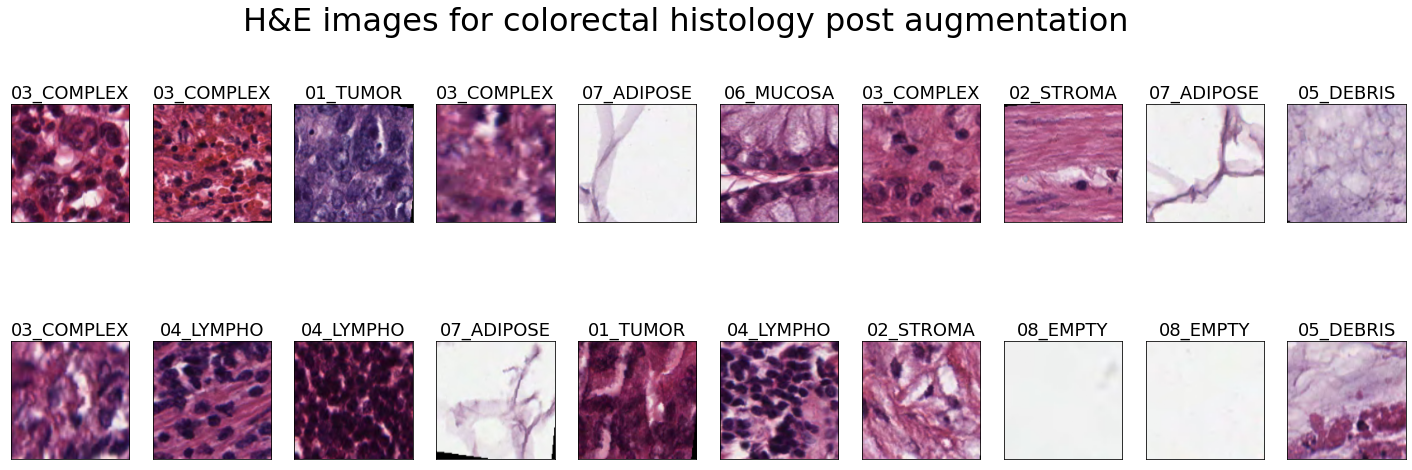

In [36]:
def imshow_transform(img):
    '''visualize images post augmentation'''
    img = img*0.5+0.5
    plt.imshow(np.transpose(img, (1,2,0)))

images, labels = next(iter(train_loader))
images = images.numpy().squeeze()
classes = train_data.classes
palette = sns.color_palette('tab10', 8)

fig = plt.figure(figsize = (25,8))
for idx in np.arange(20):
    ax = fig.add_subplot(2,10,idx+1,xticks=[], yticks=[])
    imshow_transform(images[idx])
    ax.set_title(classes[labels.numpy()[idx]], fontsize=18)
fig.suptitle('H&E images for colorectal histology post augmentation', fontsize = 32)

Build CNN model 

In [39]:
class Model(nn.Module):
    def __init__(self):
        super(Model,self).__init__()
        self.conv1_1 = nn.Conv2d(3,32,3,padding=1)
        self.conv1_2 = nn.Conv2d(32,32,3,padding=1)
        self.conv1_3 = nn.Conv2d(32,32,3,padding=1)

        self.conv2_1 = nn.Conv2d(32,64,3,padding=1)
        self.conv2_2 = nn.Conv2d(64,64,3,padding=1)
        self.conv2_3 = nn.Conv2d(64,64,3,padding=1)

        self.conv3_1 = nn.Conv2d(64,128,3,padding=1)
        self.conv3_2 = nn.Conv2d(128,128,3,padding=1)
        self.conv3_3 = nn.Conv2d(128,128,3,padding=1)

        self.pool = nn.MaxPool2d(2,2)
        self.fc1 = nn.Linear(128*18*18,256)
        self.fc2 = nn.Linear(256,8)
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = F.relu(self.conv1_1(x))
        x = F.relu(self.conv1_2(x))
        x = F.relu(self.conv1_3(x))
        x = self.pool(x)
        x = self.dropout(x)

        x = F.relu(self.conv2_1(x))
        x = F.relu(self.conv2_2(x))
        x = F.relu(self.conv2_3(x))
        x = self.pool(x)
        x = self.dropout(x)

        x = F.relu(self.conv3_1(x))
        x = F.relu(self.conv3_2(x))
        x = F.relu(self.conv3_3(x))
        x = self.pool(x)
        x = self.dropout(x)

        x = x.view(-1,128*18*18)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)

        return x

Train CNN model

In [40]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('device: {}'.format(device.type))

device: cuda


In [41]:
model = Model()
# specify loss function
criterion = nn.CrossEntropyLoss()
# specify optimizer
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [42]:
def train(n_epochs, train_loader, val_loader, model, criterion, optimizer, device, save_path):
    '''the train function will perform both forward and backpropagation on training and validation datasets.
    Output: trained model with the lowest val_loss and dataframe containing train_loss/train_acc and val_loss/val_acc for each epoch'''
    epoch_dict={}
    valid_loss_min = np.Inf
    model = model.to(device)
    for epoch in np.arange(n_epochs):
        # Initiate loss and accuracy values
        train_loss = 0.0
        train_acc = 0.0
        val_loss = 0.0
        val_acc = 0.0
        epoch_dict[epoch] = {}
        # Training
        model.train()
        for images, labels in train_loader:
            optimizer.zero_grad()
            images, labels = images.to(device), labels.to(device)
            output = model(images)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()
            ## Update loss and acc values for the training process
            train_loss += loss.item()*images.shape[0]
            _, top_class = output.topk(1,dim=1)
            equals = top_class == labels.view(*top_class.shape)
            train_acc += torch.mean(equals.type(torch.FloatTensor)).item()

        # Validation
        else:
            # turn off gradients
            with torch.no_grad():
                # set model to evaluation mode
                model.eval()
                for images, labels in val_loader:
                    images, labels = images.to(device), labels.to(device)
                    output = model(images)
                    loss = criterion(output, labels)
                    ## Update loss and acc values for the validation process
                    val_loss += loss.item()*images.shape[0]
                    _, top_class = output.topk(1,dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    val_acc += torch.mean(equals.type(torch.FloatTensor)).item()

                ### write training/validation loss/accuracy
                epoch_dict[epoch]['Train_Loss'] = train_loss/len(train_loader.sampler)
                epoch_dict[epoch]['Train_Accuracy'] = train_acc/len(train_loader)
                epoch_dict[epoch]['Val_Loss'] = val_loss/len(val_loader.sampler)
                epoch_dict[epoch]['Val_Accuracy'] = val_acc/len(val_loader)

                print("Epoch: {}/{}.. ".format(epoch+1, n_epochs),
                      "Train Loss: {:.3f}.. ".format(train_loss/len(train_loader.sampler)),
                      "Train Accuracy: {:.3f}.. ".format(train_acc/len(train_loader)),
                      "Validation Loss: {:.3f}.. ".format(val_loss/len(val_loader.sampler)),
                      "Validation Accuracy: {:.3f}".format(val_acc/len(val_loader)))
                
                ## save the model with the lowest val_loss and update valid_loss_min
                if val_loss <= valid_loss_min:
                    print('Validation loss decreased -- Saving model -- \n')
                    torch.save(model.state_dict(), save_path)
                    valid_loss_min = val_loss

    epoch_df = pd.DataFrame.from_dict(epoch_dict, orient = 'index')
    epoch_df['Epoch'] = np.arange(n_epochs)+1
    return model, epoch_df

In [51]:
n_epochs = 50
save_path = '/content/drive/MyDrive/Colab_Notebooks/models/Colorectal_histology_PyTorch_model1_epoch50_lr4_fc256.pth'
model, epoch_df = train(n_epochs, train_loader, val_loader, model, criterion, optimizer, device, save_path)

Epoch: 1/50..  Train Loss: 0.505..  Train Accuracy: 0.811..  Validation Loss: 0.495..  Validation Accuracy: 0.822
Validation loss decreased -- Saving model -- 

Epoch: 2/50..  Train Loss: 0.497..  Train Accuracy: 0.817..  Validation Loss: 0.516..  Validation Accuracy: 0.814
Epoch: 3/50..  Train Loss: 0.523..  Train Accuracy: 0.813..  Validation Loss: 0.489..  Validation Accuracy: 0.833
Validation loss decreased -- Saving model -- 

Epoch: 4/50..  Train Loss: 0.501..  Train Accuracy: 0.809..  Validation Loss: 0.491..  Validation Accuracy: 0.830
Epoch: 5/50..  Train Loss: 0.471..  Train Accuracy: 0.825..  Validation Loss: 0.541..  Validation Accuracy: 0.790
Epoch: 6/50..  Train Loss: 0.491..  Train Accuracy: 0.822..  Validation Loss: 0.486..  Validation Accuracy: 0.818
Validation loss decreased -- Saving model -- 

Epoch: 7/50..  Train Loss: 0.493..  Train Accuracy: 0.816..  Validation Loss: 0.450..  Validation Accuracy: 0.855
Validation loss decreased -- Saving model -- 

Epoch: 8/50.. 

Load the trained model

In [65]:
model = Model()
if device.type == 'cpu':
    state_dict = torch.load('/content/drive/MyDrive/Colab_Notebooks/models/Colorectal_histology_PyTorch_model1_epoch50_lr4_fc256.pth', map_location='cpu')
else:
    state_dict = torch.load('/content/drive/MyDrive/Colab_Notebooks/models/Colorectal_histology_PyTorch_model1_epoch50_lr4_fc256.pth')
model.load_state_dict(state_dict)
for param in model.parameters():
    param.requires_grad=False

Load images frim test dataset

In [66]:
class ImageFolderWithPaths(datasets.ImageFolder):
    """Custom dataset that includes image file paths. Extends
    torchvision.datasets.ImageFolder
    """

    # override the __getitem__ method. this is the method dataloader calls
    def __getitem__(self, index):
        # this is what ImageFolder normally returns 
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        # the image file path
        path = self.imgs[index][0]
        # make a new tuple that includes original and the path
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path

In [67]:
## No augmentation
test_transforms = transforms.Compose([
    transforms.Resize((144,144)),
    transforms.ToTensor(),
    transforms.Normalize([0.5,0.5,0.5], [0.5,0.5,0.5])
])
test_data = ImageFolderWithPaths(train_path, transform = test_transforms)
test_loader = torch.utils.data.DataLoader(test_data, batch_size = BATCH_SIZE, sampler = test_sampler)
print('Number of images in testing set: {}'.format(len(test_loader.sampler)))

Number of images in testing set: 750


Make prediction in test dataset

In [68]:
def model_eval(test_loader, model, criterion, device, classes):
    '''Apply the trained model to testing dataset and summarize the overall test_loss/test_acc
    also output testing accuracy for each category and the prediction result for each sample as well as the probability'''
    # Initiate loss and accuracy values
    test_loss = 0.0
    test_acc = 0.0
    class_correct = list(0. for i in range(len(classes)))
    class_total = list(0. for i in range(len(classes)))
  
    dt = np.dtype(int)
    true_label = np.array([], dtype = dt)
    pred_label = np.array([], dtype = dt)
    path_array = np.array([])
    prob_array = np.array([])
    probs_array = np.array(classes).reshape(1,-1)
    
    model = model.to(device)
    with torch.no_grad():
        model.eval()
        for images, labels, paths in test_loader:
            path_array = np.append(path_array, np.array(paths))
            images, labels = images.to(device), labels.to(device)
            output = model(images)
            loss = criterion(output, labels)
            test_loss += loss.item()*images.shape[0]
        
            softmax = nn.Softmax(dim=1)
            output_softmax = softmax(output)
            top_probs, preds = output_softmax.topk(1,dim=1)
            equals = preds == labels.view(*preds.shape)
            correct = np.squeeze(equals)
            test_acc += torch.mean(equals.type(torch.FloatTensor)).item()
            for i in range(len(images)):
                label = labels[i].item()
                class_correct[label] += correct[i].item()
                class_total[label] += 1
    
            if device.type == 'cpu':
                true_label = np.append(true_label, labels)
                pred_label = np.append(pred_label, preds)
                prob_array = np.append(prob_array, top_probs)
                probs_array = np.concatenate((probs_array, output_softmax))
      
            else:
                true_label = np.append(true_label, labels.cpu())
                pred_label = np.append(pred_label, preds.cpu())
                prob_array = np.append(prob_array, top_probs.cpu())
                probs_array = np.concatenate((probs_array, output_softmax.cpu()))
            
      
    test_loss = test_loss/len(test_loader.sampler)
    test_acc = test_acc/len(test_loader)
    print('Test Loss: {:.6f}\n'.format(test_loss))
    print('Test Accuracy (Overall): {:.3f}%  ({}/{})\n'.format(np.sum(class_correct)/np.sum(class_total)*100, np.sum(class_correct), np.sum(class_total)))
  
    for i in range(len(classes)):
        if class_total[i] > 0:
            print('Test Accuracy of {}: {:.3f}% ({}/{})'.format(classes[i], class_correct[i]/class_total[i]*100,class_correct[i], class_total[i]))
        else:
            print('Test Accuracy of {}: N/A'.format(classes[i]))
    summary_df = pd.DataFrame({'category': classes, 'correct': class_correct, 'total': class_total})
    pred_df = pd.DataFrame({'file_path': path_array, 'true_label': true_label, 'prediction': pred_label, 'prob': prob_array})
    probs_df = pd.DataFrame(probs_array[1:], columns = probs_array[0])
    probs_df['file_path'] = path_array
    pred_df = pred_df.merge(probs_df, left_on = 'file_path', right_on = 'file_path')
    return summary_df, pred_df

In [69]:
criterion = nn.CrossEntropyLoss()
classes = test_data.classes
summary_df, pred_df = model_eval(test_loader, model, criterion, device, classes)

Test Loss: 0.326366

Test Accuracy (Overall): 89.200%  (669.0/750.0)

Test Accuracy of 01_TUMOR: 95.455% (84.0/88.0)
Test Accuracy of 02_STROMA: 68.293% (56.0/82.0)
Test Accuracy of 03_COMPLEX: 78.947% (75.0/95.0)
Test Accuracy of 04_LYMPHO: 89.362% (84.0/94.0)
Test Accuracy of 05_DEBRIS: 90.000% (90.0/100.0)
Test Accuracy of 06_MUCOSA: 93.750% (90.0/96.0)
Test Accuracy of 07_ADIPOSE: 97.938% (95.0/97.0)
Test Accuracy of 08_EMPTY: 96.939% (95.0/98.0)


Text(7.4, 83, 'Avg:\n83.6%')

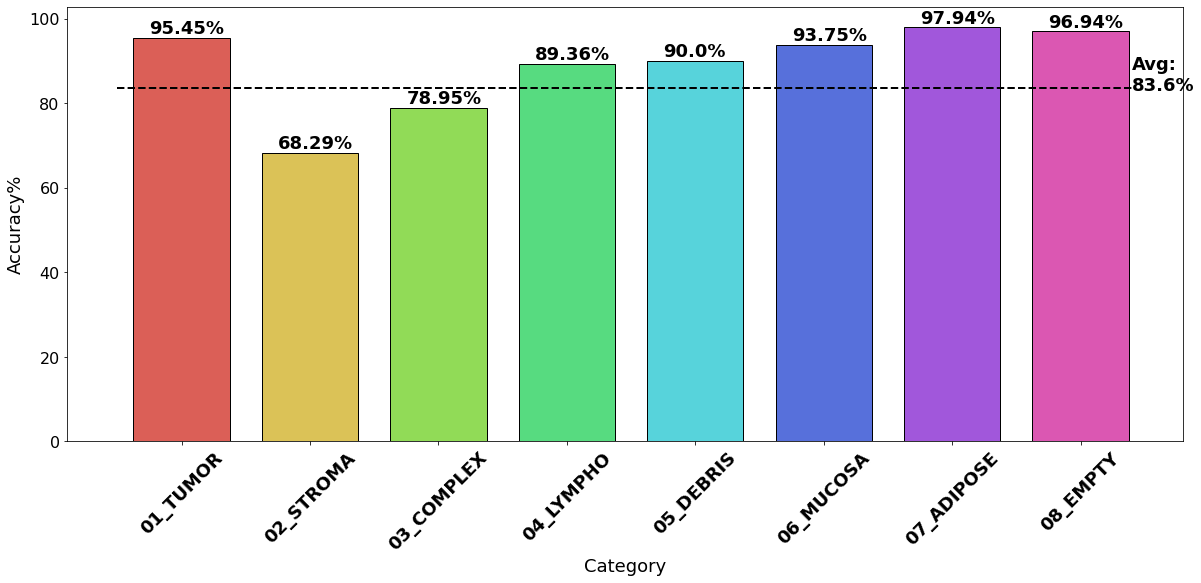

In [70]:
summary_df['accuracy'] = np.round(summary_df.correct/summary_df.total*100,2)
fig = plt.figure(figsize = (20,8))
ax = fig.add_subplot(1,1,1)
width = 0.75 # the width of the bars 
ind = np.arange(len(classes))  # the x locations for the groups
ax.bar(ind, summary_df.accuracy, width, edgecolor='black', color = sns.color_palette('hls', 8))
plt.xticks(ind, labels = classes, fontsize=18, fontweight='bold', rotation=45)
plt.yticks(fontsize=16)
plt.xlabel('Category', fontsize=18)
plt.ylabel('Accuracy%', fontsize=18)
for i, v in enumerate(summary_df.accuracy):
    ax.text(i-0.25, v + 1, str(np.round(v,2))+'%', fontweight='bold', fontsize=18)
ax.plot([-0.5, 7.4], [83.600, 83.600], "k--", linewidth=2)
ax.text(7.4, 83, 'Avg:\n'+str(83.600)+'%', fontweight='bold', fontsize=18)

Evaluate model performance

In [71]:
cm = confusion_matrix(pred_df.true_label, pred_df.prediction)

In [72]:
def plot_confusion_matrix(cm, classes,title='Confusion matrix',cmap=plt.cm.Blues):    
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=26)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize=12, fontweight='bold')
    plt.yticks(tick_marks, classes, fontsize=12, fontweight='bold')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, '{:d} \n({:.2f}%)'.format(cm[i, j], cm[i,j]/cm.sum()*100), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=20)
    plt.xlabel('Predicted label', fontsize=20)
    plt.tight_layout()

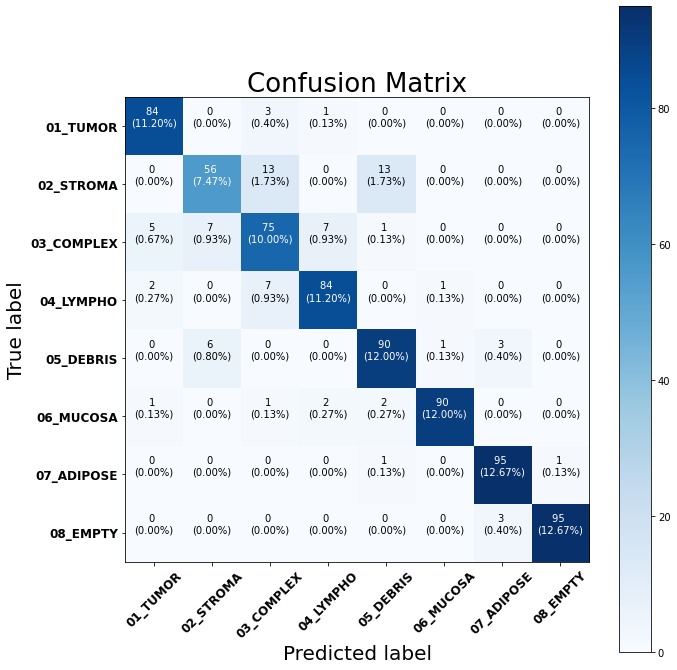

In [73]:
plot_confusion_matrix(cm, classes, title = 'Confusion Matrix')